In [1]:
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Load model and mask
model = YOLO("/Users/macbook/Pengujian/models/yolov8n.pt")
mask = cv2.imread("/Users/macbook/Pengujian/datasets_test/mask.jpg", cv2.IMREAD_GRAYSCALE)

In [3]:
# Function to draw bounding boxes
def draw_boxes(result, frame):
    blank = np.zeros(frame.shape, dtype=np.uint8)
    image = frame.copy()
    for box in result.boxes:
        x1, y1, x2, y2 = [round(x) for x in box.xyxy[0].tolist()]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
        cv2.rectangle(blank, (x1, y1), (x2, y2), (255, 255, 255), -1)
    blank = cv2.bitwise_and(blank, blank, mask=mask)
    blank = cv2.cvtColor(blank, cv2.COLOR_BGR2GRAY)
    return blank, image

# Detection function
def detect(frame, threshold=30, show=True):  # Adjust the default threshold here if needed
    image = cv2.imread(frame)
    masked = cv2.bitwise_and(image, image, mask=mask)
    result = model(masked, conf=0.25, verbose=False)
    area, image = draw_boxes(result[0], image)
    percentage = round((np.sum(area) / np.sum(mask)) * 100, 2)
    label = "ramai" if percentage > threshold else "tidak ramai"  # Use the threshold parameter
    return label, percentage

In [4]:
# Path to dataset images
path = "/Users/macbook/Pengujian/datasets/images"
images = os.listdir(path)

# Filter file gambar dan abaikan file sistem seperti .DS_Store
images = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

# Read true labels
true_labels = pd.read_csv("/Users/macbook/Pengujian/datasets_test/true_labels.csv")

# Initialize result dataframe
results = []

# Detect and save results
for image in images:
    label, percentage = detect(os.path.join(path, image), threshold=30, show=False)  # Adjust the threshold here if needed
    true_label = true_labels[true_labels['images'] == image]['labels'].values[0]
    results.append([image, true_label, label, percentage])

# Save results to CSV
results_df = pd.DataFrame(results, columns=["image", "true_label", "predicted_label", "percentage"])
results_df.to_csv("/Users/macbook/Pengujian/datasets_result/result_with_labels_n.csv", index=False)

# Load results
df = pd.read_csv("/Users/macbook/Pengujian/datasets_result/result_with_labels_n.csv")

# Display all rows
print(df)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


                                                image   true_label  \
0   ramai_8_mp4-0025_jpg.jpg63d622dfcc2d66f3f45f4e...        ramai   
1   tidak_ramai_10_mp4-0038_jpg.jpgdb3c75808810dbb...  tidak ramai   
2   ramai_3_mp4-0026_jpg.jpg2a340706ee80442d166405...        ramai   
3   tidak_ramai_8_mp4-0020_jpg.jpgd2eb612433eaf56b...  tidak ramai   
4   tidak_ramai_9_mp4-0002_jpg.jpg9618ae536d879ffb...  tidak ramai   
..                                                ...          ...   
95  ramai_8_mp4-0018_jpg.jpgb877d327219a8a4bf2026b...        ramai   
96  tidak_ramai_1_mp4-0023_jpg.jpg099d23f6cce55469...  tidak ramai   
97  ramai_8_mp4-0033_jpg.jpg206cfd65c8ccae3752b738...        ramai   
98  ramai_5_mp4-0004_jpg.jpg6c71e46a23dab3b6b50ce5...        ramai   
99  ramai_3_mp4-0016_jpg.jpg075dff1724214600787287...        ramai   

   predicted_label  percentage  
0            ramai       43.17  
1      tidak ramai       10.92  
2            ramai       34.38  
3      tidak ramai       10

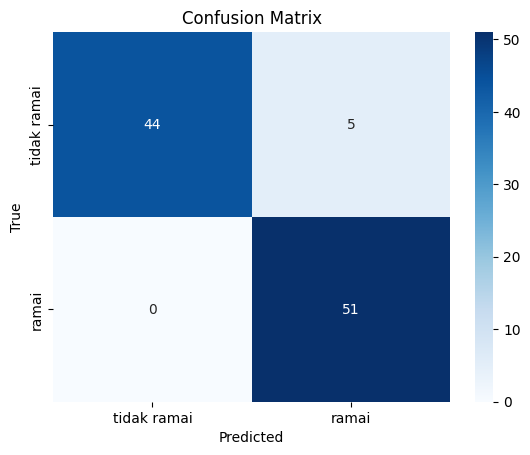

              precision    recall  f1-score   support

 tidak ramai       1.00      0.90      0.95        49
       ramai       0.91      1.00      0.95        51

    accuracy                           0.95       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



In [5]:
# Calculate and display confusion matrix
cm = confusion_matrix(df['true_label'], df['predicted_label'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["tidak ramai", "ramai"], yticklabels=["tidak ramai", "ramai"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(df['true_label'], df['predicted_label'], target_names=["tidak ramai", "ramai"]))